In [1]:
ROBBER = "R"
POLICE = "P"
BANK = "B"
EMPTY = "*"

grid = [
    [ROBBER,EMPTY,EMPTY,EMPTY],
    [EMPTY,BANK,EMPTY,EMPTY],
    [EMPTY,EMPTY,EMPTY,EMPTY],
    [EMPTY,EMPTY,EMPTY, POLICE]
]

for row in grid:
    print(' '.join(row))

R * * *
* B * *
* * * *
* * * P


In [2]:
class State:
    
    def __init__(self, robber_pos, police_pos):
        self.robber_pos = robber_pos
        self.police_pos = police_pos
        
    def __eq__(self, other):
        return isinstance(other, State) and self.robber_pos == other.robber_pos and self.police_pos == other.police_pos
    
    def __hash__(self):
        return hash(str(self.robber_pos) + str(self.police_pos))
    
    def __str__(self):
        return f"State(robber_pos={self.robber_pos}, police_pos={self.police_pos})"

In [3]:
STAY = 0
UP = 1
DOWN = 2 
LEFT = 3
RIGHT = 4

ACTIONS = [STAY, UP, DOWN, LEFT, RIGHT]

REWARD_BANK = 1
REWARD_EMPTY = 0
REWARD_CAUGHT = -10

START_ROBBER = [0,0]
START_POLICE = [3,3]

In [4]:
start_state = State(robber_pos=START_ROBBER, police_pos=START_POLICE)

In [5]:
from copy import deepcopy

def act(state,action_robber,action_police):
    def new_actor_pos(state,state_actor_pos,action):
        p = deepcopy(state_actor_pos)
        if action == UP:
            p[0] = max(0,p[0]-1)
        elif action == DOWN:
            p[0] = min(3, p[0]+1)
        elif action == LEFT:
            p[1] = max(0, p[1]-1)
        elif action == RIGHT:
            p[1] = min(3, p[1]+1)
        elif action == STAY:
            p = p
        else:
            raise ValueError(f"Unknown action {action}")
        return p
    
    pos_robber = new_actor_pos(state,state.robber_pos,action_robber)
    pos_police = new_actor_pos(state,state.police_pos,action_police)
    
    if pos_robber == pos_police:
        reward = REWARD_CAUGHT
    elif pos_robber == [1,1]:
        reward = REWARD_BANK
    else:
        reward = REWARD_EMPTY
        
    return State(robber_pos=pos_robber, police_pos=pos_police), reward


    

In [6]:
import numpy as np
import random
random.seed(42)

N_STATES = 16*16
ITERATIONS = 10000000

eps = 1
LAMBDA = 0.8

q_table = dict()


In [7]:
def q(state, action_robber=None):
    
    if state not in q_table:
        q_table[state] = np.zeros(len(ACTIONS))
    if action_robber is None: 
        return q_table[state]
    
    return q_table[state][action_robber]



In [8]:
def choose_action(state):
    pos_robber = state.robber_pos
    pos_police = state.police_pos
    if pos_police[0] == 0:
        if pos_police[1] == 0:
            action_police = random.choice([ACTIONS[2],ACTIONS[4]])
        elif pos_police[1] == 3:
            action_police = random.choice([ACTIONS[2],ACTIONS[3]])
        else:
            action_police = random.choice(ACTIONS[2:5])
    elif pos_police[0] == 3:
        if pos_police[1] == 0:
            action_police = random.choice([ACTIONS[1],ACTIONS[4]])
        elif pos_police[1] == 3:
            action_police = random.choice([ACTIONS[1],ACTIONS[3]])
        else:
            action_police = random.choice([ACTIONS[1],ACTIONS[3],ACTIONS[4]])
    elif pos_police[1] == 0:
        action_police = random.choice([ACTIONS[1],ACTIONS[2],ACTIONS[4]])
    elif pos_police[1] == 3:
        action_police = random.choice(ACTIONS[1:4])
    else: 
        action_police = random.choice(ACTIONS[1:])
        
    if random.uniform(0, 1) < eps:   
        if pos_robber[0] == 0:
            if pos_robber[1] == 0:
                action_robber = random.choice([ACTIONS[0],ACTIONS[2],ACTIONS[4]])
            elif pos_robber[1] == 3:
                action_robber = random.choice([ACTIONS[0],ACTIONS[2],ACTIONS[3]])
            else:
                action_robber = random.choice([ACTIONS[0],ACTIONS[2],ACTIONS[3],ACTIONS[4]])
        elif pos_robber[0] == 3:
            if pos_robber[1] == 0:
                action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[4]])
            elif pos_robber[1] == 3:
                action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[3]])
            else:
                action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[3],ACTIONS[4]])
        elif pos_robber[1] == 0:
            action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[2],ACTIONS[4]])
        elif pos_robber[1] == 3:
            action_robber = random.choice(ACTIONS[0:4])
        else: 
            action_robber = random.choice(ACTIONS)
    else:
        action_robber = np.argmax(q(state))
    
    return action_robber, action_police


In [9]:
index_matrix = np.arange(16).reshape((4,4))
state_index_matrix = np.arange(16*16).reshape((16,16))
policy_matrix = np.zeros((16,16))+10 # 10, to make sure an action is choosen in all states

def state_matrix(state):
    pos_police = state.police_pos
    pos_robber = state.robber_pos
    # police along rows, robber along columns
    col_r = index_matrix[pos_robber[0]][pos_robber[1]]
    row_p = index_matrix[pos_police[0]][pos_police[1]]
    state_index = state_index_matrix[row_p][col_r]
    
    best_move = np.argmax(q(state))
    policy_matrix[row_p][col_r] = best_move
    
    return(state_index)

In [10]:
state = start_state
total_reward = 0

# Choose another intersting state to plot
other_state = State(robber_pos=[1,1], police_pos=[2,1])
# What state to plot
plot_state = other_state
plot_string = "Value in state 149"

values = []
times = []
rewards = []

n_updates_Q = np.zeros((len(ACTIONS),16*16))

for t in range(ITERATIONS):
    
    action_robber, action_police = choose_action(state)
    next_state, reward = act(state, action_robber, action_police)
    total_reward += reward

    state_index = state_matrix(state)
    n_updates_Q[action_robber][state_index] += 1
    alpha = 1/(n_updates_Q[action_robber][state_index]**(2/3))

    q(state)[action_robber] = q(state, action_robber) + \
            alpha * (reward + LAMBDA *  np.max(q(next_state)) - q(state, action_robber))
    
    if t%10000==0:
        # Look at the first state or other state taking the action with max q value
        values.append(max(q(plot_state)))
        times.append(t)
        rewards.append(total_reward)
        #print(max(q(start_state)))
        #print(t) 

    state = next_state

print(n_updates_Q)

0.0
0
2.053523667690038
10000
2.720612107953783
20000
2.8942866805969425
30000
3.0672506180570456
40000
3.15028537836804
50000
3.1844787593935773
60000
3.203053568214523
70000
3.2288256025649793
80000
3.2522099742893875
90000
3.2635355385564977
100000
3.2825017454596974
110000
3.2955452038845707
120000
3.307344676071021
130000
3.32381706967964
140000
3.334122616844978
150000
3.3408592924147533
160000
3.3441609195280946
170000
3.3518718994275183
180000
3.3559325376714386
190000
3.359474084719078
200000
3.36522602689203
210000
3.368323157725371
220000
3.3733725203037705
230000
3.3748943167999834
240000
3.3748943167999834
250000
3.3762304653900204
260000
3.37771562979251
270000
3.3799451850403908
280000
3.379647973888601
290000
3.381501170121614
300000
3.3828317833067922
310000
3.3857233148108796
320000
3.3896866398697165
330000
3.3912490287033132
340000
3.3944658386566835
350000
3.398446461483485
360000
3.40256405707175
370000
3.4061880000883114
380000
3.408704348927372
390000
3.41269800

3.4309599275847615
3160000
3.4308787416850155
3170000
3.43058621639622
3180000
3.4305604561606513
3190000
3.430529898503082
3200000
3.430380224902806
3210000
3.430332282381223
3220000
3.430289282490104
3230000
3.429953195273555
3240000
3.4297479320115563
3250000
3.4296045315439363
3260000
3.4297845758474117
3270000
3.429734291572621
3280000
3.429785006849767
3290000
3.42972532764048
3300000
3.4296705041447453
3310000
3.4295458642976264
3320000
3.4294603199695324
3330000
3.429367080558548
3340000
3.429231705289802
3350000
3.42913571581067
3360000
3.429037627322336
3370000
3.4289738327090054
3380000
3.428951398183182
3390000
3.4289075267415243
3400000
3.428930208799598
3410000
3.428891359244208
3420000
3.428928809710259
3430000
3.429169881276978
3440000
3.42921723882457
3450000
3.429214777495474
3460000
3.429200877666527
3470000
3.4291684127999207
3480000
3.429164335918843
3490000
3.4292008732230475
3500000
3.4291871544362986
3510000
3.4291905677192247
3520000
3.42913803508192
3530000
3.

3.429793276275352
6260000
3.429731956073937
6270000
3.4296889647908824
6280000
3.4296476932082385
6290000
3.429375548813435
6300000
3.429288511384497
6310000
3.4290605058035273
6320000
3.4289359607389227
6330000
3.428847121194335
6340000
3.428822668622834
6350000
3.4287873835255622
6360000
3.428773155378821
6370000
3.428695489092487
6380000
3.4286188037185323
6390000
3.428507519470437
6400000
3.4282799048462715
6410000
3.4282087756242148
6420000
3.4280732210197313
6430000
3.4279092162119693
6440000
3.427631194972233
6450000
3.4274100695561813
6460000
3.427317829280583
6470000
3.4272321660251683
6480000
3.427179071010062
6490000
3.42710647752481
6500000
3.4269126606119795
6510000
3.4268183668670504
6520000
3.426742024526272
6530000
3.426586133807185
6540000
3.426539896884606
6550000
3.4263612803920327
6560000
3.426257847840929
6570000
3.4262392452651227
6580000
3.426132579830057
6590000
3.426055587131124
6600000
3.4259729905890004
6610000
3.4258714169213835
6620000
3.4258086830851804
66

3.4288419447381497
9360000
3.4288119045004892
9370000
3.42884380815626
9380000
3.428873043132162
9390000
3.428875232335689
9400000
3.4288201208236995
9410000
3.4287218522911567
9420000
3.4286230456813747
9430000
3.428626567525291
9440000
3.4286437106283194
9450000
3.428563118885785
9460000
3.4284140660818405
9470000
3.428434967571859
9480000
3.4284223133811693
9490000
3.4283860916792297
9500000
3.4283300109863393
9510000
3.4282974931155206
9520000
3.4282624474156265
9530000
3.4282243760472744
9540000
3.4281625185204794
9550000
3.4281484493775047
9560000
3.4281565345267366
9570000
3.428105132605862
9580000
3.4281463388159645
9590000
3.4281171394832137
9600000
3.4282308738886234
9610000
3.4282045296904617
9620000
3.4282171524521825
9630000
3.428208996320849
9640000
3.4281614562601845
9650000
3.428102620313927
9660000
3.428003511392415
9670000
3.4279456204796657
9680000
3.4278241643638574
9690000
3.4277515024143135
9700000
3.4276759343629624
9710000
3.427641407992169
9720000
3.42761128063

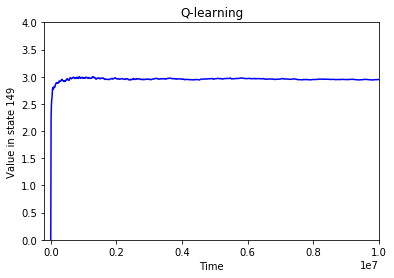

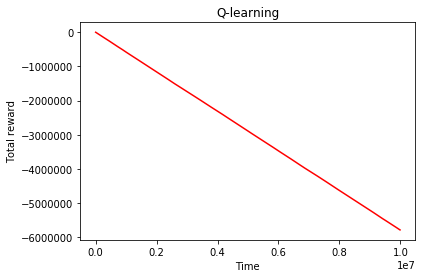

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(times,values,'b')
plt.title("Q-learning")
plt.xlabel("Time")
plt.ylabel(plot_string)
plt.xlim(-200000, 10000000)
plt.ylim(0, 4.0)
plt.show()

plt.plot(times,rewards,'r')
plt.title("Q-learning")
plt.xlabel("Time")
plt.ylabel("Total reward")
plt.show()

In [12]:
print(len(q_table))

256


In [13]:
def get_spec_policy(grid_index_police):
    print(policy_matrix)
    fixed_police = policy_matrix[grid_index_police]
    fixed_police_policy = fixed_police.reshape(4,4)
    police_idx = np.where(index_matrix==grid_index_police)
    fixed_police_policy[police_idx[0][0]][police_idx[1][0]] = 9
    print(fixed_police_policy)

get_spec_policy(11)

[[0. 2. 0. 3. 4. 0. 3. 3. 4. 1. 1. 1. 4. 0. 3. 3.]
 [4. 0. 3. 0. 0. 4. 0. 3. 4. 0. 3. 3. 1. 1. 1. 3.]
 [2. 2. 0. 2. 4. 0. 3. 0. 1. 1. 3. 3. 1. 1. 1. 3.]
 [2. 2. 2. 0. 4. 0. 3. 3. 1. 1. 1. 3. 1. 1. 3. 1.]
 [2. 0. 3. 2. 0. 3. 0. 3. 1. 0. 1. 3. 0. 1. 1. 3.]
 [0. 2. 0. 2. 4. 0. 3. 0. 0. 1. 0. 3. 1. 0. 3. 3.]
 [4. 0. 2. 0. 0. 2. 0. 3. 1. 0. 1. 0. 1. 1. 3. 3.]
 [4. 2. 3. 3. 4. 0. 3. 0. 1. 1. 3. 3. 1. 1. 1. 3.]
 [4. 2. 2. 2. 4. 0. 3. 3. 0. 1. 1. 1. 1. 0. 1. 1.]
 [2. 0. 3. 3. 0. 3. 0. 3. 1. 0. 1. 1. 0. 1. 0. 3.]
 [2. 2. 3. 3. 4. 0. 3. 0. 1. 1. 0. 1. 4. 0. 3. 0.]
 [4. 2. 2. 3. 4. 0. 3. 3. 1. 1. 1. 0. 1. 1. 3. 3.]
 [2. 2. 3. 3. 4. 0. 3. 3. 1. 1. 3. 1. 0. 1. 1. 1.]
 [2. 2. 2. 2. 4. 0. 3. 3. 1. 1. 1. 3. 4. 0. 1. 1.]
 [2. 2. 2. 3. 4. 0. 3. 3. 1. 1. 1. 1. 1. 1. 0. 1.]
 [2. 2. 2. 3. 4. 0. 3. 3. 1. 1. 1. 3. 1. 1. 1. 0.]]
[[4. 2. 2. 3.]
 [4. 0. 3. 3.]
 [1. 1. 1. 9.]
 [1. 1. 3. 3.]]


In [14]:
print(n_updates_Q)
print(q(other_state))
print(state_matrix(other_state))

[[6370. 6370. 6521. ... 6575. 6506. 6646.]
 [   0.    0.    0. ... 6548. 6501. 6503.]
 [6370. 6444. 6630. ...    0.    0.    0.]
 [   0. 6380. 6427. ... 6564. 6578. 6425.]
 [6468. 6551. 6623. ... 6520. 6471.    0.]]
[0.94690324 2.93639079 2.92362475 2.94595094 2.93832084]
149
